In [34]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Polynomials")
Pkg.add("NPZ")
Pkg.add("DataFrames")
print(VERSION)

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...


1.4.2

   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


In [4]:
using NPZ
data = npzread("OUN_sN05.npy")
data

┌ Info: Precompiling NPZ [15e1cf62-19b3-5cfa-8e77-841668bca605]
└ @ Base loading.jl:1260


100×10000 Array{Float64,2}:
  0.695645   -0.196227   -0.0833162  …   0.429272  -0.727756   -1.27726
  0.309394   -0.101541    1.68684       -0.666451  -1.58008    -0.80955
  1.57953     1.46807     1.03161       -3.00528   -2.63157    -2.67002
 -0.0492703   0.987882   -0.651309      -1.16846   -1.80954    -2.84546
 -0.675556   -1.41109    -0.271162      -0.212757  -0.368881   -0.391366
  0.195932    0.500997   -0.428191   …   0.593691   0.304862    0.792327
  0.949015    1.20706     0.437401       0.678526   1.02505     0.502847
  0.42947     0.792742    1.27861       -1.36399   -1.6097     -2.03679
 -0.0979523   0.211529    0.7332        -0.111135   0.220068   -0.691014
 -0.209525    0.34216     0.922132       1.64222    1.19842     0.971373
 -1.83477    -0.906878   -0.602141   …  -0.783334  -0.684024   -0.943618
 -0.0174318   0.695489   -0.31721        0.428936   0.39325     0.330471
 -1.65036    -0.598615   -0.089858       0.988408   0.74325     0.291927
  ⋮                         

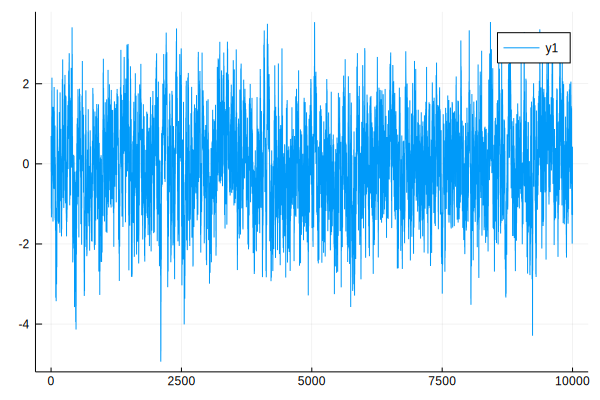

In [9]:
using Plots
plot(data[1,:])

In [10]:
using Polynomials
# function to calculate A and B from the dataset
function OUEM(data1sq,dataNsq,datasq,datacorr,N)
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    broots = roots(B_coef)
#    println(broots)
    B=broots[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUEMresult(data1sq,dataNsq,datasq,datacorr,N,deltat)
    A, dA, B ,dB = OUEM(data1sq,dataNsq,datasq,datacorr,N)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

┌ Info: Precompiling Polynomials [f27b6e38-b328-58d1-80ce-0feddd5e7a45]
└ @ Base loading.jl:1260


OUEMresult (generic function with 1 method)

In [24]:
# function to multiply two Gaussians
function mul_gauss(mu1,mu2,sigma1,sigma2)
    mu = (mu1*sigma2^2+mu2*sigma1^2)/(sigma1^2+sigma2^2)
    sigma = sqrt(sigma1^2*sigma2^2/(sigma1^2+sigma2^2))
    return mu,sigma
end

# function to convolute two Gaussians
function con_gauss(mu1,mu2,sigma1,sigma2)
    mu = mu1 + mu2
    sigma = sqrt(sigma1^2+sigma2^2)
    return mu,sigma
end

# function to calculate helper function alpha (forward)
function alpha(y,sigmaN,A,B)
    N = length(y)
    sig_alpha = zeros(N)
    mu_alpha = zeros(N)
    mu_alpha[1],sig_alpha[1] = mul_gauss(0,y[1],sqrt(A),sigmaN)
    for i=2:N
        mu_temp,sig_temp = con_gauss(B*mu_alpha[i-1],0,sqrt(A*(1-B^2)),B*sig_alpha[i-1])
        mu_alpha[i],sig_alpha[i] = mul_gauss(mu_temp,y[i],sig_temp,sigmaN)
    end
    return mu_alpha,sig_alpha
end

function beta(y,sigmaN,A,B)
    N = length(y)
    sig_beta = zeros(N-1)
    mu_beta  = zeros(N-1)
    mu_beta[N-1],sig_beta[N-1] = y[N]/B,sqrt(sigmaN^2+A*(1-B^2))/B
    for i=(N-2):-1:1
        mu_temp,sig_temp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        mu_beta[i],sig_beta[i] = mu_temp/B,sqrt(sig_temp^2+A*(1-B^2))/B
    end
    return mu_beta,sig_beta
end

function px(y,sigmaN,A,B)
    N = length(y)
    mu_px = zeros(N)
    sig_px = zeros(N)
    exxpone = zeros(N-1)
    rho = zeros(N-1)
    mu_x = zeros(N-1)
    mu_xpone = zeros(N-1)
    mu_alpha,sig_alpha = alpha(y,sigmaN,A,B)
    mu_beta,sig_beta = beta(y,sigmaN,A,B)
    for i=1:N-1
        mu_px[i],sig_px[i] = mul_gauss(mu_alpha[i],mu_beta[i],sig_alpha[i],sig_beta[i])
        if i==N-1
            mu_tmp,sig_tmp = y[N],sigmaN
        else
            mu_tmp,sig_tmp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        end
        # these are the polynomial coefficients of the distribution
        a = 1.0/(2*sig_tmp)+1.0/(2*(A*(1-B^2)))
        b = 1.0/(2*sig_alpha[i])+B^2/(2*(A*(1-B^2)))
        c = -B/(A*(1-B^2))
        d = -mu_tmp/sig_tmp^2
        e = -mu_alpha[i]/sig_alpha[i]^2
        rho[i] = -c/(2*sqrt(a*b))
        exxpone[i] = -c/(4*a*b-c^2)
        mu_xpone[i] = (2*b*d+c*e)/(4*a*b-c^2)
        mu_x[i] = (2*a*e+d*c)/(4*a*b-c^2)
    end
    # for last one beta = 1
    mu_px[N] = mu_alpha[N]
    sig_px[N] = sig_alpha[N]
    # it seems that the sign of mu_x and mu_xpone are not accuaratly determined by this method
    # we need to correct the signs.  We chose the sign so that mu_x[i] is closest to mu_px[i]
    # and mu_xpone[i] is closeset to mu_px[i+1]
    nswitch=0
    for i=1:N-1
        dx1 = abs(mu_x[i]-mu_px[i])
        dx2 = abs(-mu_x[i]-mu_px[i])
        dxp1 = abs(mu_xpone[i]-mu_px[i+1])
        dxp2 = abs(-mu_xpone[i]-mu_px[i+1])
        if dx1>dx2
            nswitch = nswitch+1
            mu_x[i] = -mu_x[i]
        end
        if dxp1>dxp2
            nswitch = nswitch+1
            mu_xpone[i] = -mu_xpone[i]
        end
    end
    return mu_px,sig_px,rho,exxpone,mu_x,mu_xpone,nswitch
end

function px2(y,sigmaN,A,B)
    N = length(y)
    mu_px = zeros(N)
    sig_px = zeros(N)
    exxpone = zeros(N-1)
    mu_alpha,sig_alpha = alpha(y,sigmaN,A,B)
    mu_beta,sig_beta = beta(y,sigmaN,A,B)
    for i=1:N-1
        mu_px[i],sig_px[i] = mul_gauss(mu_alpha[i],mu_beta[i],sig_alpha[i],sig_beta[i])
        if i==N-1
            mu_tmp,sig_tmp = y[N],sigmaN
        else
            mu_tmp,sig_tmp = mul_gauss(mu_beta[i+1],y[i+1],sig_beta[i+1],sigmaN)
        end
        term1 = A*(1-B^2)
        term2 = term1^2 *mu_tmp*mu_alpha[i]
        term3 = B^2*mu_tmp*mu_alpha[i]*sig_alpha[i]^2
        term4 = B*mu_tmp^2*sig_alpha[i]^2
        term5 = mu_tmp*mu_alpha[i]*sig_tmp^2
        term6 = B*(mu_alpha[i]^2+sig_alpha[i]^2)*sig_tmp^2
        term7 = 2*B*mu_tmp*mu_alpha[i]*sig_alpha[i]^2*sig_tmp^2
        term8 = (mu_alpha[i]^2+sig_alpha[i]^2)*sig_tmp^4
        term9 = B^2*sig_alpha[i]^4*(mu_tmp^2+sig_tmp^2)
        term10 = (B^2*sig_alpha[i]^2+sig_tmp^2+term1)^2
        exxpone[i] = (term2 +term1*(term3+term4+term5+term6)+B*(term7+term8+term9))/term10
        
    end
    # for last one beta = 1
    mu_px[N] = mu_alpha[N]
    sig_px[N] = sig_alpha[N]
    return mu_px,sig_px,exxpone
end

px2 (generic function with 1 method)

In [32]:
function OUWN(data,A_s,B_s,sigN_s,convth,itermax=10000)
    N=length(data)
    A_p = A_s
    B_p = B_s
    sigN_p = sigN_s
    for i=1:itermax
        mu_px,sig_px,exxpone = px2(data,sigN_p,A_p,B_p)
        # lets calculate all the values that we need for OU analysis
        # data1sq,dataNsq,datasq,datacorr
        data1sq = sig_px[1]^2 + mu_px[1]^2
        dataNsq = sig_px[end]^2 + mu_px[end]^2
        datasq = sum(sig_px[2:end-1].^2 .+ mu_px[2:end-1].^2)
        datacorr = sum(exxpone)
        global A,dA,B,dB,sigmaN
        A,dA,B,dB=OUEM(data1sq,dataNsq,datasq,datacorr,N)
        sigmaN = sqrt((sum(sig_px .^2) + sum(mu_px .^2) + sum(data .^2) -2*sum((mu_px .* data)))/length(data))
#        println("A: ",A,"  B: ",B,"  SigmaN: ",sigmaN)
        Arel = abs((A-A_p)/A_p)
        Brel = abs((B-B_p)/B_p)
        srel = abs((sigmaN-sigN_p)/sigN_p)
        if (Arel<convth && Brel<convth && srel<convth)
            break
        end
        A_p = A
        B_p = B
        sigN_p = sigmaN
    end
    return A,dA,B,dB,sigmaN
end

OUWN (generic function with 2 methods)

In [35]:
using DataFrames
# iterate over the dataset and estimate the best parameters
paradf = DataFrame(A=Float64[],dA=Float64[],B=Float64[],dB=Float64[],sigmaN=Float64[])
for i=1:size(data,1)
    push!(paradf,OUWN(data[i,:],1.0,0.9,0.5,0.0001))
end
paradf

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1260


,A,dA,B,dB,sigmaN
,Float64,Float64,Float64,Float64,Float64
1,0.985064,0.0456296,0.910881,0.00412372,0.508974
2,1.05782,0.0480541,0.90748,0.00419814,0.5089
3,0.992871,0.0444297,0.904438,0.00427189,0.49765
4,1.02004,0.0468221,0.909149,0.00416602,0.514454
5,0.886939,0.0392735,0.902828,0.00429726,0.515484
6,1.02875,0.0466956,0.907357,0.00420021,0.496388
7,0.945529,0.041072,0.899178,0.00437349,0.495464
8,1.07801,0.0493592,0.908775,0.00417253,0.481669
9,0.963229,0.0423476,0.901519,0.00432385,0.493256
